# Star 69

###  Draft RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_04_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "Star69"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-10-29_ListStar69.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list only considers projects with open source GitHub repos that have received more",
                "than 69 stars. The list identifies when the project received its 69th star and allocates",
                "OP Tokens based on how many days it's been since then. In other words, it favors popular,",
                "older OSS projects over newer and/or less popular OSS projects."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 100000000

JSON_PATH = DATA_DIR + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
#oso.check_duplicate_slugs()

Loaded 308 OSS projects from data/RPGF3/2023-11_04_RPGF3_cleaned_applicant_data.json.
Identified 308 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
stopper = 69
query = f"""
    WITH RankedEvents AS (
        SELECT
            e.time,
            p.slug,
            ROW_NUMBER() OVER (PARTITION BY p.slug ORDER BY e.time) AS row_num
        FROM
            event e
        LEFT JOIN
            project_artifacts_artifact paa ON e."toId" = paa."artifactId"
        LEFT JOIN
            project p ON paa."projectId" = p."id"
        WHERE
            p.slug IN ('{slugs_list}')
            AND e."typeId" = 21
    )
    SELECT
        time,
        slug
    FROM
        RankedEvents
    WHERE
        row_num <= {stopper}
    ORDER BY
        slug,
        time;
"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

project_dates = defaultdict(list)

for date_str, project in results:
    project_dates[project].append(date_str)

project_ages = {}

for project, dates in project_dates.items():
    if len(dates) >= stopper:
        project_ages[project] = (datetime.now().timestamp() - dates[stopper-1].timestamp()) / (60*60*24)
    else:
        project_ages[project] = 0

# Generate the list

In [6]:
named_list = listify(project_ages, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

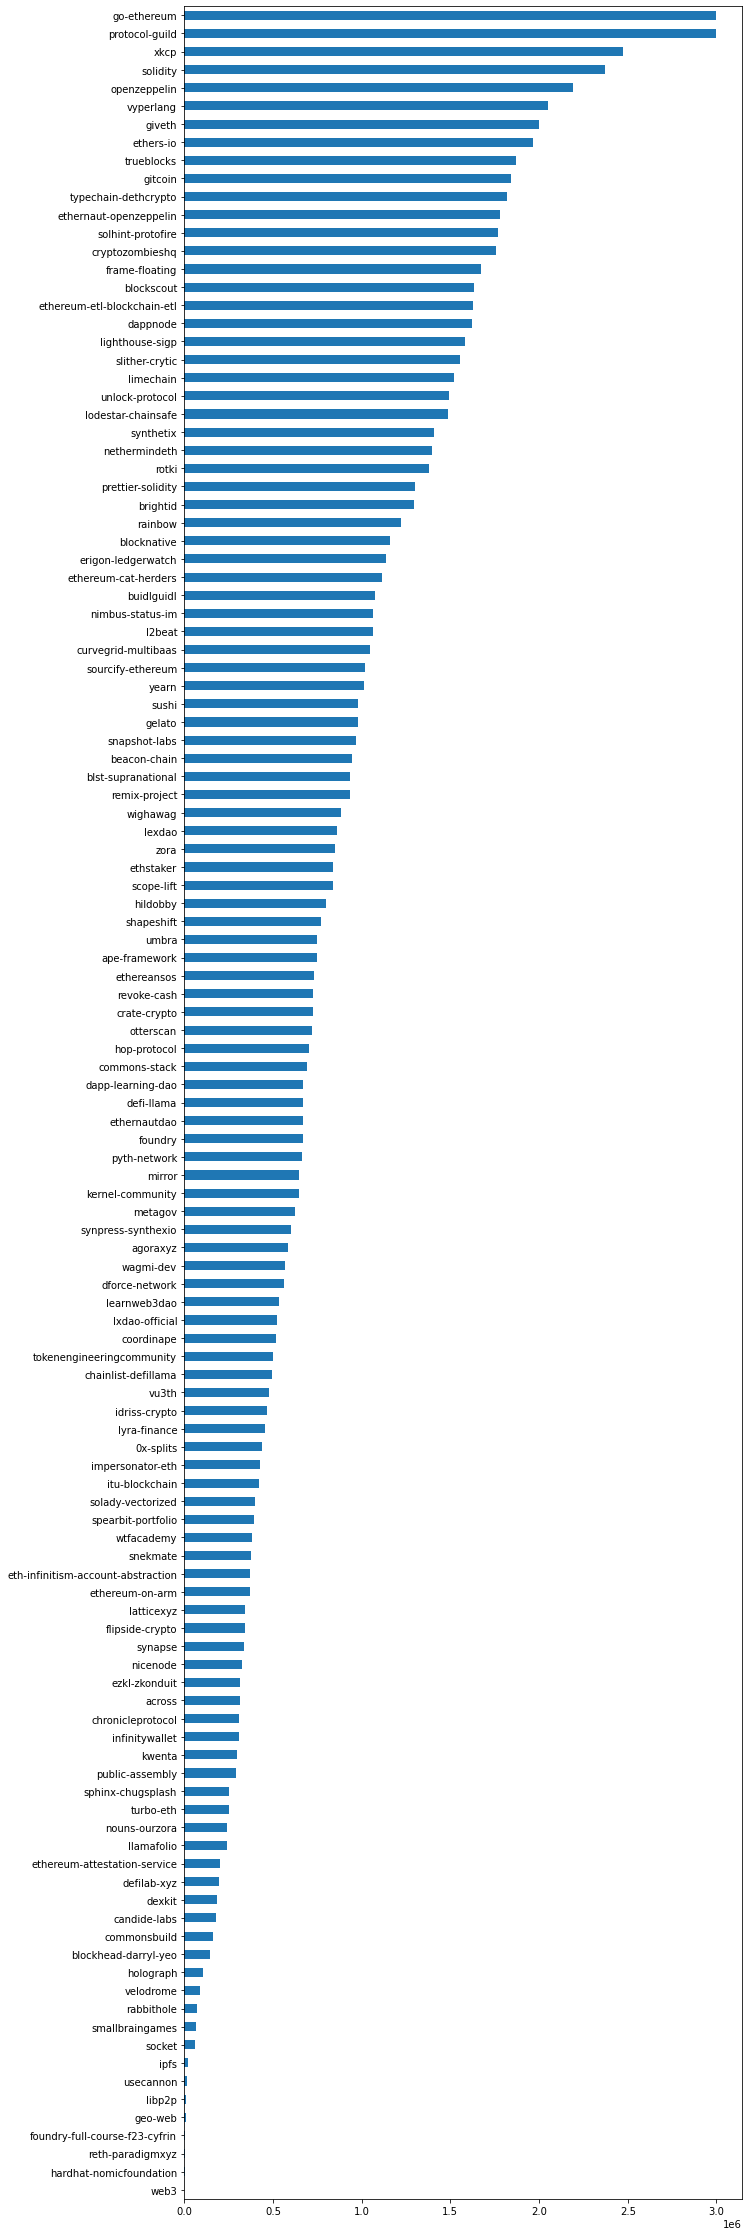

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)